# Model evaluation

In this notebook, I will compare the accuracy metrics of models

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import scienceplots  # noqa # pylint: disable=unused-import

plt.style.use(["science", "ieee", "default"])
plt.rcParams.update({"axes.grid": True})

In [4]:
from tqdm.auto import tqdm

## Prepare dataloader

In [5]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [6]:
from collections import defaultdict

import lightning.pytorch as pl
import torch
from lightning.pytorch import Trainer, seed_everything
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import get_metrics

In [7]:
torch.set_default_dtype(torch.float32)

take only 1 dataset, 1 concrete time series for now...

In [8]:
DATA_DIR = ROOT_DATA_DIR / "KPI-Anomaly-Detection/Preliminary_dataset"

In [9]:
df = pd.read_parquet(DATA_DIR / "train.parquet")
df.rename(columns={"label": "target"}, inplace=True)
df = df[df["KPI ID"] == "02e99bd4f6cfb33f"].copy()
df = df[df.index > 1.49 * 1e9].copy()
df = df.query("timestamp < 1496538120").copy()
df["time"] = df.index - df.index[0]
# df["value"] = df["value"].diff()
# df = df.query('stock==1 & day==0 & train==1')
# df.value = df.value.pct_change()
df.dropna(inplace=True)

In [10]:
def convert_to_windows(x, window_size):
    # convert input time series x to
    # time series of lags, first window_size observations are dropped
    windows = []
    for i in range(window_size, len(x)):
        w = x[i - window_size : i]
        windows.append(w)
    windows = np.array(windows)
    return windows

In [11]:
df["value_diff"] = df["value"].diff()
tr_cols = ["value", "value_diff"]
df = df.dropna()

In [54]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(df.value.diff())
# plt.subplot(1, 2, 2)
# plt.hist(df.value)
# plt.yscale("log")
# plt.tight_layout();

In [55]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-5
epochs = 30

In [56]:
x = df[tr_cols].values.copy()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# x_scaled = x
x = convert_to_windows(x, window_size)
y = df["target"].values
y = y[window_size:]

# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y.ravel())
# class_weights = class_weights / class_weights.sum()

x = torch.Tensor(x).float()
y = torch.Tensor(y).float()

train_idx = int(len(x) * train_proportion)
# train_idx = int(1.495 * 1e9)

tr, va = x[:train_idx], x[train_idx:]
# x = np.hstack([x, y.reshape(-1, 1)])
# y = y.reshape(-1, 1)
ytr, yva = y[:train_idx], y[train_idx:]
tr_dataset = TensorDataset(tr, ytr)
va_dataset = TensorDataset(va, yva)

In [57]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.sca(axs[0])
# plt.plot(tr[:, 0, 0])
# plt.sca(axs[1])
# plt.plot(tr[:, 0, 1])
# fig.tight_layout();

## Evaluate models

In [58]:
from src.transformer import TransformerAnomalyDetector, TransformerEncoder
from src.utils import MetricTracker

### Scaled Dot-Product

In [59]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 100

In [60]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


> **TODO**: add positional enocding

See the code for Anomaly BERT -> implement sequences windows for tensors -> unsqueeze before supplying to the model

In [95]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "num_heads": 2,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": True,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}


model = TransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
positional encoding disabled


In [96]:
# https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.LearningRateFinder.html#learningratefinder

from lightning.pytorch.callbacks import LearningRateFinder

In [97]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker()],
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_62746e46-7fa1-4164-a3a9-c479adaebb3b.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_62746e46-7fa1-4164-a3a9-c479adaebb3b.ckpt

  | Name                | Type               | Params
-----------------------------------------------------------
0 | front_linear        | Linear             | 24    
1 | positional_encoder  | Identity           | 0     
2 | transformer_encoder | TransformerEncoder | 576   
3 | final_linear        | Linear             | 9     
4 | loss_fn             | BCEWithLogitsLoss  | 0     
-----------------------------------------------------------
609       Trainable params
0         Non-trainable params
609       Total params
0.002     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/i

Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [98]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 2952), started 0:23:42 ago. (Use '!kill 2952' to kill it.)

In [65]:
# dir(trainer)

In [99]:
mt = trainer.callbacks[1]

In [100]:
from copy import deepcopy
res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

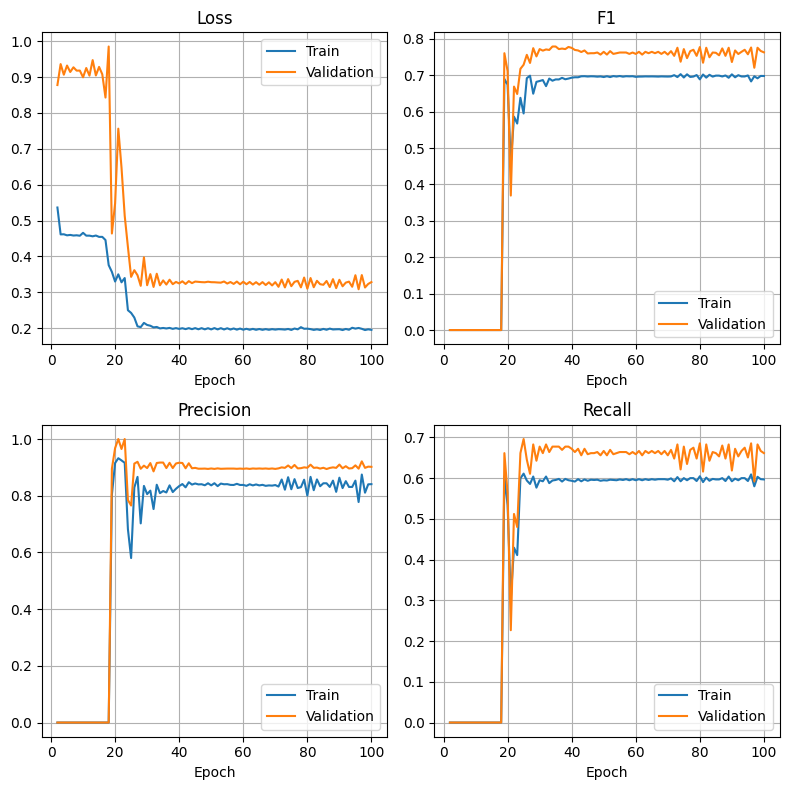

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

## compare to Linear regression

## compare to Linear Attention

## Linear attention

implementation: https://github.com/idiap/fast-transformers

paper: https://arxiv.org/pdf/2006.16236.pdf

In [ ]:
from src.transformer import LinearTransformer

In [ ]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-3 / 2
epochs = 30

input_dim = len(tr_cols)
embed_dim = 8
num_heads = 1

In [ ]:
seed_everything(1)

# TODO: sampling might be useful for some datasets
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
# tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
seed_everything(1)
model = LinearTransformer(input_dim=input_dim, num_heads=num_heads, embed_dim=embed_dim)

In [ ]:
model

In [ ]:
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
seed_everything(1)

res_dict = {}
res_dict["tr_metrics"] = []
res_dict["va_metrics"] = []
verbose = True
for epoch in tqdm(range(epochs)):
    if verbose:
        print(epoch)
    _ = train_loop(
        dataloader=tr_dl,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )
    curr_metrics = test_loop(dataloader=tr_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print("train", curr_metrics)
    res_dict["tr_metrics"].append(curr_metrics)
    curr_metrics = test_loop(dataloader=va_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print("val", curr_metrics)
    res_dict["va_metrics"].append(curr_metrics)

    if verbose:
        print()  # empty line

res_dict["tr_metrics"] = pd.DataFrame(res_dict["tr_metrics"])
res_dict["va_metrics"] = pd.DataFrame(res_dict["va_metrics"])

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res_dict["tr_metrics"]["loss"], label="Train")
plt.plot(res_dict["va_metrics"]["loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res_dict["tr_metrics"]["f1"], label="Train")
plt.plot(res_dict["va_metrics"]["f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res_dict["tr_metrics"]["precision"], label="Train")
plt.plot(res_dict["va_metrics"]["precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res_dict["tr_metrics"]["recall"], label="Train")
plt.plot(res_dict["va_metrics"]["recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();